In [1]:
! pip install xgboost

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [33]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20



In [4]:
train = pd.read_csv('C:/Users/Alekh/Downloads/all/train.csv')
#test = pd.read_csv('../input/train.csv')

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

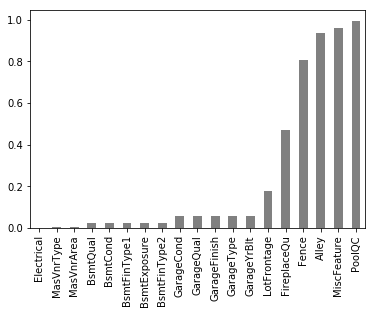

In [5]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing=missing/train['Id'].count()
missing.sort_values(inplace=True)
missing.plot.bar(color='grey')

In [6]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

C:\Users\Alekh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Alekh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Alekh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


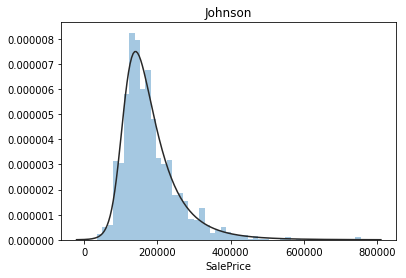

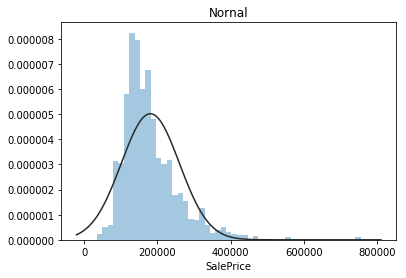

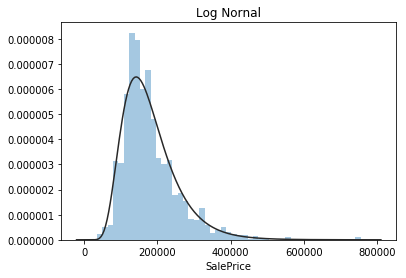

In [7]:
import scipy.stats as st
y=train['SalePrice']
plt.figure(1); plt.title('Johnson')
sns.distplot(y,kde=False,fit=st.johnsonsu)
plt.figure(2); plt.title('Nornal')
sns.distplot(y,kde=False,fit=st.norm)
plt.figure(3); plt.title('Log Nornal')
sns.distplot(y,kde=False,fit=st.lognorm)
plt.show()

In [8]:
f=pd.melt(train,value_vars=quantitative)

C:\Users\Alekh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Alekh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Alekh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Alekh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Alekh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:

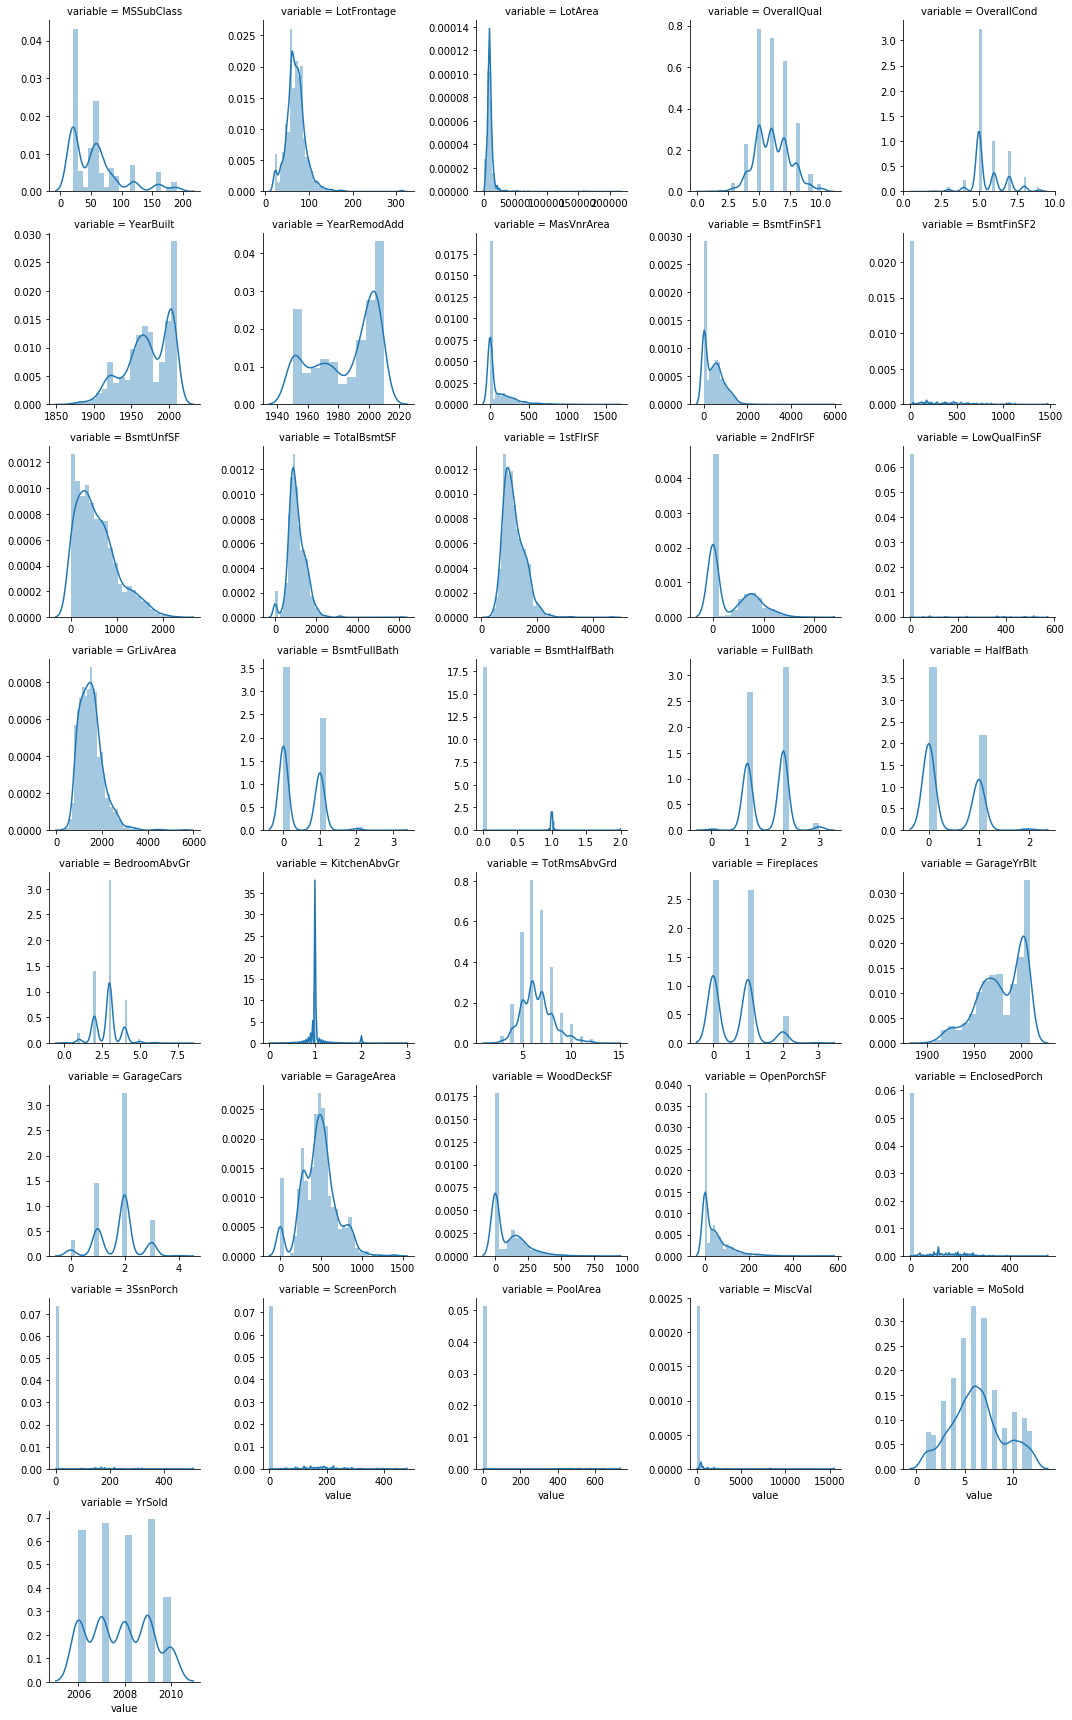

In [9]:
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [10]:
###TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea

In [11]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')


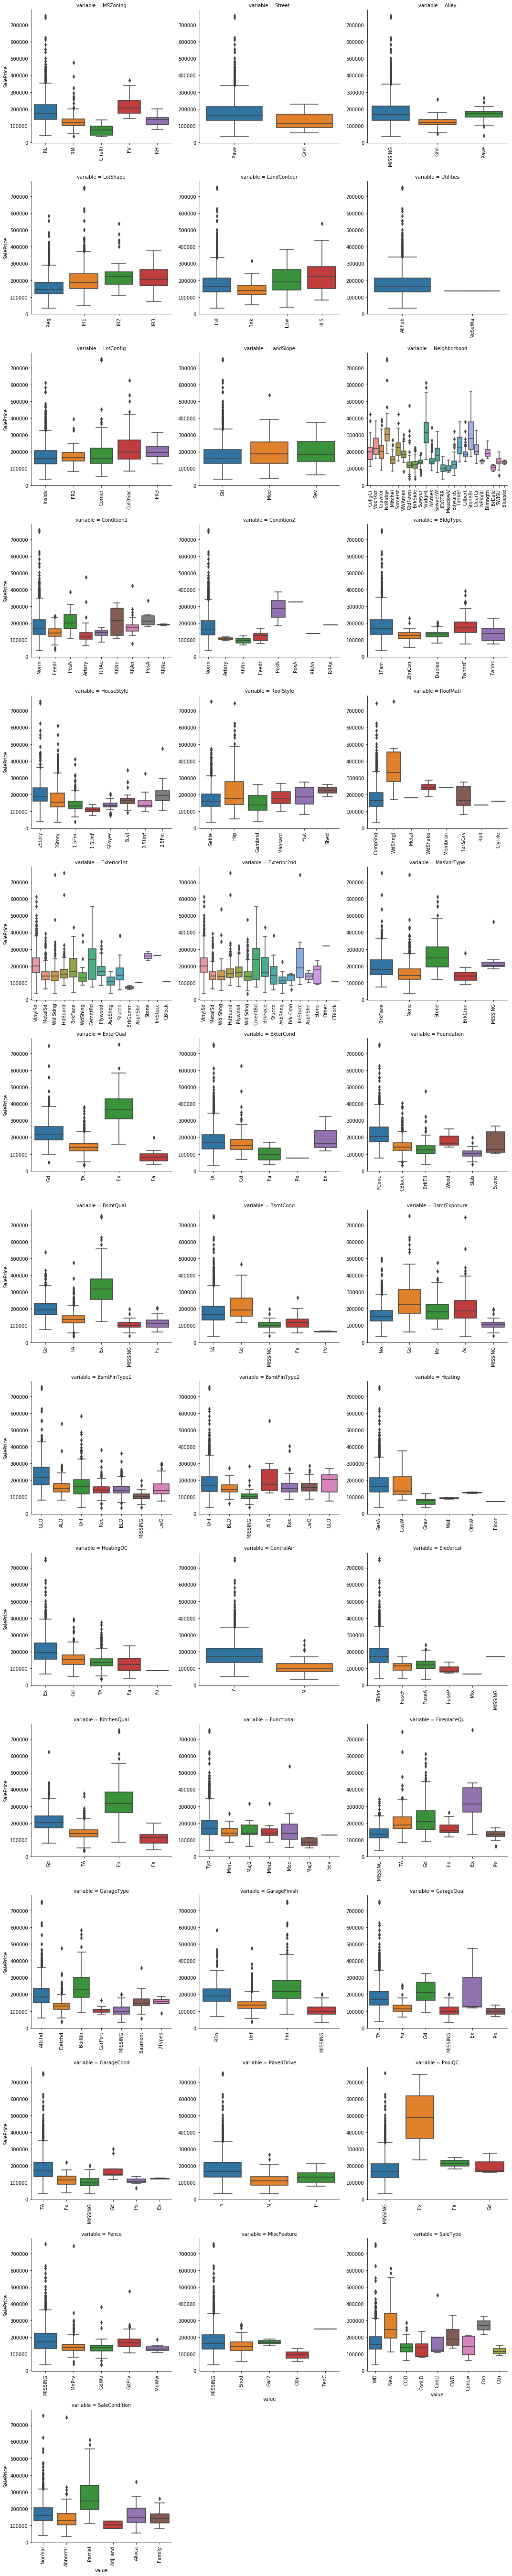

In [12]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")


In [13]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    #print(ordering.items())
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [14]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E',
       'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E',
       'SaleCondition_E'],
      dtype='object', length=124)

In [15]:
x=[20,22,28,23,30,30,23,24]
y=[28,24,24,25,26,27,32,20]

In [16]:
from scipy.stats import spearmanr
spearmanr(x,y)

SpearmanrResult(correlation=-0.13333578213051497, pvalue=0.752942730804063)

In [17]:
x=[1,2,3,4,5]
y=[5,4,3,2,1]
spearmanr(x,y)

SpearmanrResult(correlation=-0.9999999999999999, pvalue=1.4042654220543672e-24)

In [18]:
sns.axes_style("darkgrid")

{'figure.facecolor': 'white',
 'text.color': '.15',
 'axes.labelcolor': '.15',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.linestyle': '-',
 'lines.solid_capstyle': 'round',
 'axes.grid': True,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'axes.linewidth': 0,
 'grid.color': 'white',
 'xtick.major.size': 0,
 'ytick.major.size': 0,
 'xtick.minor.size': 0,
 'ytick.minor.size': 0}

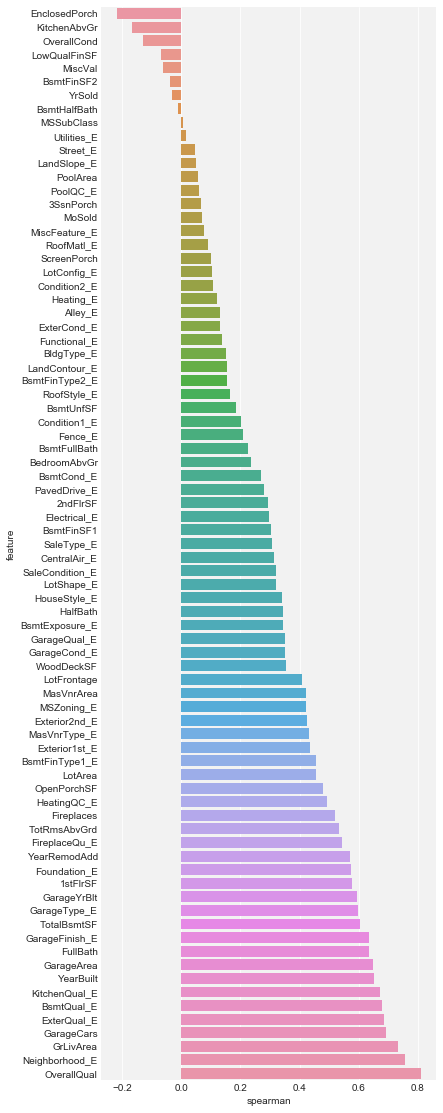

In [19]:
def spearman(frame,features):
    spr=pd.DataFrame()
    spr['feature']=features
    spr['spearman']=[frame[f].corr(frame['SalePrice'],'spearman') for f in features]
    spr=spr.sort_values('spearman')
    plt.figure(figsize=(6,len(features)*0.25))
    sns.set_style("darkgrid", {"axes.facecolor": "0.95"})
    sns.barplot(data=spr,y='feature',x='spearman',orient='h')
    
    
features=quantitative+qual_encoded
spearman(train,features)

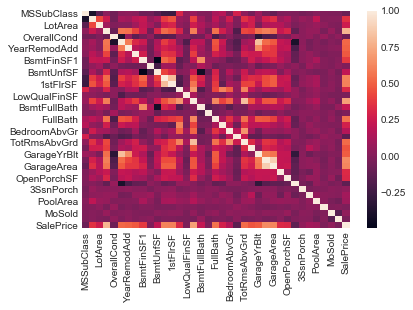

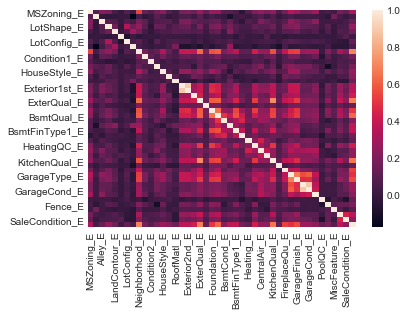

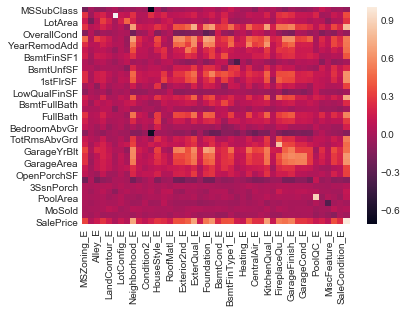

In [20]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)


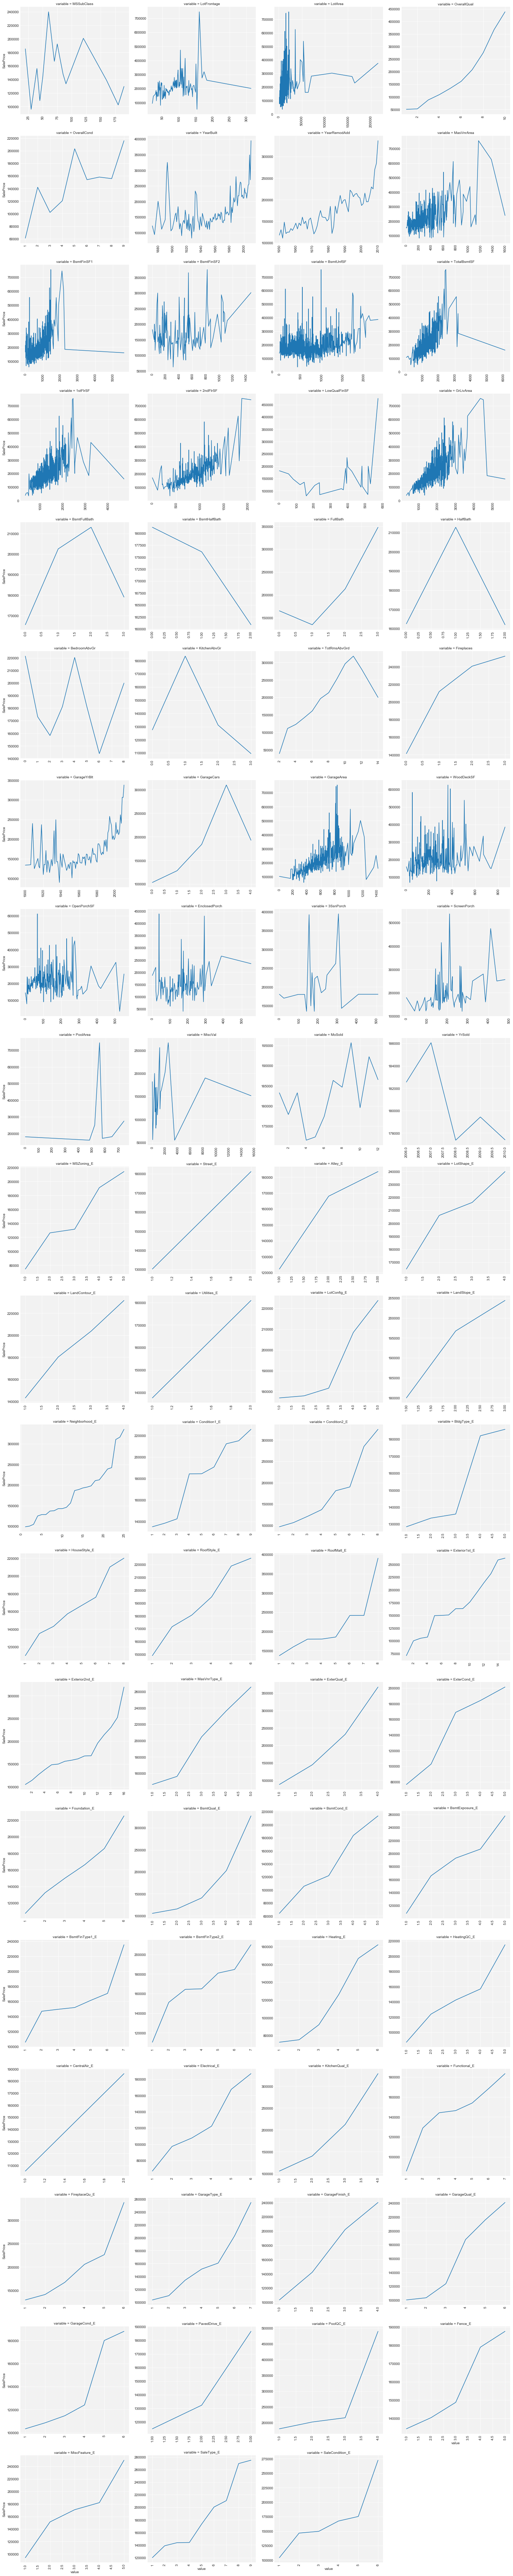

In [21]:
def pairplot(x,y,**kwargs):
    ax=plt.gca()
    ts=pd.DataFrame({'time':x,'val':y})
    ts=ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f=pd.melt(train,id_vars=['SalePrice'],value_vars=quantitative+qual_encoded)
g=sns.FacetGrid(f,col='variable',col_wrap=4, sharex=False, sharey=False, size=5)
g=g.map(pairplot,"value","SalePrice")
    

In [23]:
train.shape

(1460, 124)

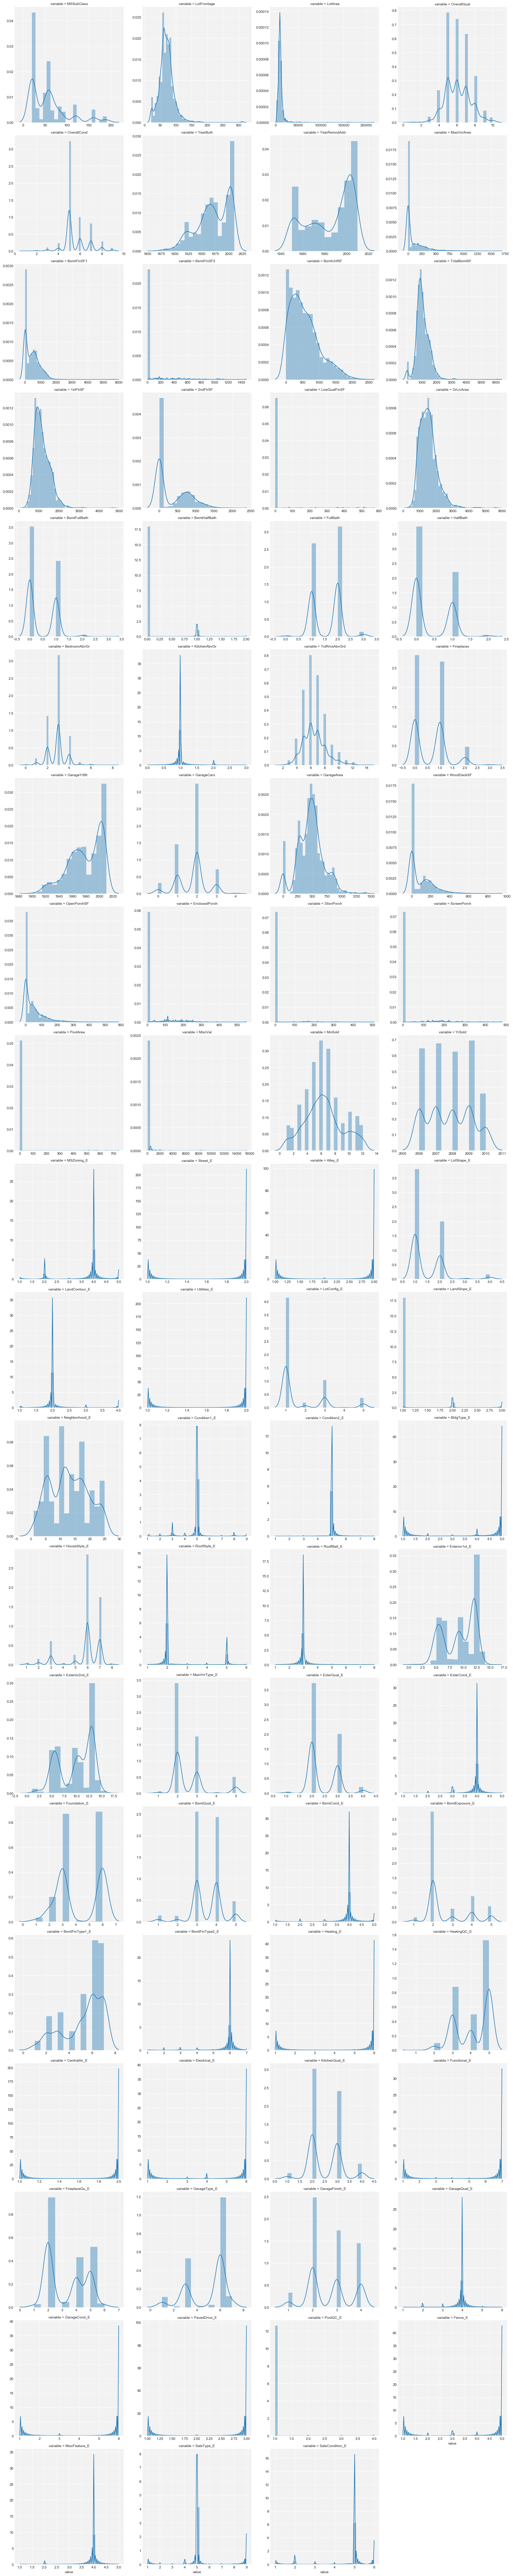

In [34]:
import warnings
warnings.filterwarnings("ignore")

def distplot(x, **kwargs):
    sns.distplot(x)
    



f=pd.melt(train,value_vars=quantitative+qual_encoded)
g=sns.FacetGrid(f,col='variable',col_wrap=4, sharex=False, sharey=False, size=5)
g=g.map(distplot,"value")

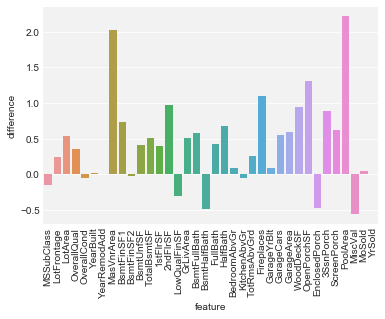

In [41]:
features=quantitative

standard=train[train['SalePrice']<200000]
pricy=train[train['SalePrice']>=200000]

diff=pd.DataFrame()
diff['feature']=features
diff['difference']=[(pricy[f].fillna(0.).mean()-standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean()) for f in features]


#diff['difference'] = [(pricey[f].mean() - standard[f].mean())/(standard[f].mean())
#                      for f in features]

sns.barplot(data=diff,x='feature',y='difference')
x=plt.xticks(rotation=90)

In [44]:
features=quantitative+qual_encoded
model=TSNE(n_components=2,random_state=0,perplexity=50)
X=train[features].fillna(0.).values
tsne=model.fit_transform(X)


0.749840156352844


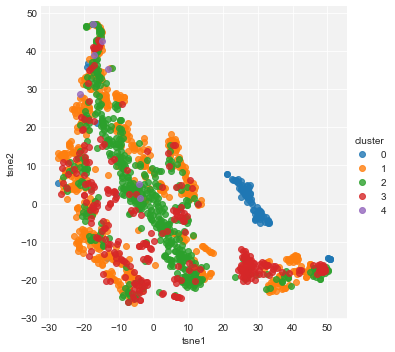

In [46]:
std=StandardScaler()
s=std.fit_transform(X)
pca=PCA(n_components=30)
pca.fit(s)
pc=pca.transform(s)
kmeans=KMeans(n_clusters=5)
kmeans.fit(pc)

fr=pd.DataFrame({'tsne1':tsne[:,0],'tsne2':tsne[:,1],'cluster':kmeans.labels_})
sns.lmplot(data=fr,x='tsne1',y='tsne2',hue='cluster',fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

In [47]:
def error(actual,predicted):
    actual=np.log(actual)
    predicted=np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature]=np.log1p(train[feature].values)
    
def quadratic(feature):
    train[feature+'2']=train[feature]**2
    
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')


In [48]:
qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = train[features].fillna(0.).values
Y = train['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

0.1126326901784323

In [49]:
import patsy

Y, X = patsy.dmatrices(
    "SalePrice ~ \
        GarageCars + \
        np.log1p(BsmtFinSF1) + \
        ScreenPorch + \
        Condition1_E + \
        Condition2_E + \
        WoodDeckSF + \
        np.log1p(LotArea) + \
        Foundation_E + \
        MSZoning_E + \
        MasVnrType_E + \
        HouseStyle_E + \
        Fireplaces + \
        CentralAir_E + \
        BsmtFullBath + \
        EnclosedPorch + \
        PavedDrive_E + \
        ExterQual_E + \
        bs(OverallCond, df=7, degree=1) + \
        bs(MSSubClass, df=7, degree=1) + \
        bs(LotArea, df=2, degree=1) + \
        bs(FullBath, df=3, degree=1) + \
        bs(HalfBath, df=2, degree=1) + \
        bs(BsmtFullBath, df=3, degree=1) + \
        bs(TotRmsAbvGrd, df=2, degree=1) + \
        bs(LandSlope_E, df=2, degree=1) + \
        bs(LotConfig_E, df=2, degree=1) + \
        bs(SaleCondition_E, df=3, degree=1) + \
        OverallQual + np.square(OverallQual) + \
        GrLivArea + np.square(GrLivArea) + \
        Q('1stFlrSF') + np.square(Q('1stFlrSF')) + \
        Q('2ndFlrSF') + np.square(Q('2ndFlrSF')) +  \
        TotalBsmtSF + np.square(TotalBsmtSF) +  \
        KitchenAbvGr + np.square(KitchenAbvGr) +  \
        YearBuilt + np.square(YearBuilt) + \
        Neighborhood_E + np.square(Neighborhood_E) + \
        Neighborhood_E:OverallQual + \
        MSSubClass:BldgType_E + \
        ExterQual_E:OverallQual + \
        PoolArea:PoolQC_E + \
        Fireplaces:FireplaceQu_E + \
        OverallQual:KitchenQual_E + \
        GarageQual_E:GarageCond + \
        GarageArea:GarageCars + \
        Q('1stFlrSF'):TotalBsmtSF + \
        TotRmsAbvGrd:GrLivArea",
    train.to_dict('list'))

ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))
Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))

0.11602320727290498
